# AnimationWidget. Basics

Introduction
============

This notebook presents the animationwidget. It provides a periodic timer. This timer delivers a pulse that can drive animations in a notebook.

Under the hull, this widget uses the javascript [setTimeout() function](http://www.w3schools.com/jsref/met_win_settimeout.asp) to periodically change a value in a Python model. This value can then be connected to other widgets.

For more details about widgets , I recommend the [PyDataParis2016 tutorial by Sylvain Corlet](https://github.com/SylvainCorlay/PyDataParis2016/blob/master/Index.ipynb)

In [1]:
from __future__ import print_function
import animationwidget

In [2]:
w = animationwidget.AnimationWidget()

In [3]:
w

The widget has the following attributes:
* value: a float in [0,1] interval. The timer periodically changes this value
* run: a boolean that triggers the timer. 
* period: signal period (in milliseconds). It is the time for the counter to go from 0.0 to 1.0
* sampling: sampling rate, interval between two pulses of the trigger.

In [4]:
w.run = True

### First Animation

In this first example, we visualize the timer value into a matplotlib plot. 

First, we need a special buffer to get a window on the last signal values. The RingBufferArray is a ring buffer that will store the last N values into a numpy array

In [5]:
import numpy as np

class RingBufferArray(object):
    """
    A class that keep a window of the N last values
    """
    def __init__(self, size, dtype):
        """
        :param size: windows size
        :param dtype: data type
        """
        self._values = np.zeros(size, dtype=dtype)
        self._start_index = 0
        self._len = size
        

    def __call__(self, new_value):
        """
        Add the new value to the window. Return the full signal
        """
        # Push value
        self._values[self._start_index] = new_value
        self._start_index = (self._start_index + 1) % self._len
        return np.append(self._values[self._start_index:], self._values[:self._start_index])


Then, we create a viewer based on matplotlib that will render the values into the ring buffer.

The update method:
* Update the ring buffer with the new value from the timer
* Then render using matplotlib

We connect the timer events to the update method using the observe method

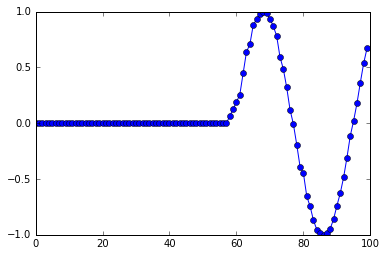

In [6]:
import math
import matplotlib.pyplot as plt
from ipywidgets import ToggleButton
from traitlets import link
from IPython.display import display, clear_output
%matplotlib inline


class SignalViewer(object):
    def __init__(self, size, fun_to_visualize):
        """
        :param size: size of ring buffer (number of points to visualize)
        :param fig_size: figure dimension
        """
        self.buff = RingBufferArray(size, np.float64)
        self.x = np.arange(size)
        self.fun = fun_to_visualize
        self.fig, self.ax = plt.subplots(1, 1)
        
    def update(self, new_value):
        """
        Update the window and replot the figure
        """
        # Add the new point to the buffer ring
        ypoints = self.buff(self.fun(new_value))
        # Replot 
        self.ax.cla()
        self.ax.set_ylim(-1.0, 1.0)
        self.ax.plot(self.x, ypoints, 'o-')
        # Clear the previous display
        clear_output(wait=True)
        # Display the new one
        display(self.fig)

def sinus(val):
    return math.sin(2.0*math.pi*val)
        
s = SignalViewer(100, sinus)
anim = animationwidget.AnimationWidget()
anim.loop = True

button = ToggleButton(description="run", default=False)
link((button, 'value'), (anim, 'run'))
display(anim)
display(button)

# Connect timer to view
anim.observe(lambda value: s.update(value["new"]), names='value')

### Double buffering



In [7]:
class DoubleBufferingSignalView(object):
    def __init__(self, size, fun_to_visualize):
        """
        :param size: buffer ring size
        :param figsize: figure size (in pixel)
        """
        self.buff = RingBufferArray(size, np.float64)
        self.x = np.arange(size)
        self.fun = fun_to_visualize
        self.fig, self.ax = plt.subplots(1, 1)
        figsize = animationwidget.get_fig_size(self.fig)
        self.img = animationwidget.Image()
        self.img.width = "{0}px".format(figsize[0])
        self.img.height = "{0}px".format(figsize[1])
        # Render 
        animationwidget.plot_into_img_widget(self.img, self.fig)
        # Remove the original matplotlib plot
        plt.close()
        clear_output(wait=True)
        # Display image 
        display(self.img)
    
    def update(self, new_value):
        """
        Update the window and replot the figure
        """
        # Add the new point to the buffer ring
        ypoints = self.buff(self.fun(new_value))
        # Replot 
        self.ax.cla()
        self.ax.set_ylim(-1, 1)
        self.ax.plot(self.x, ypoints, 'o-')
        animationwidget.plot_into_img_widget(self.img, self.fig)
        

s = DoubleBufferingSignalView(100, sinus)
anim = animationwidget.AnimationWidget()
anim.loop = True

button = ToggleButton(description="run", default=False)
link((button, 'value'), (anim, 'run'))
display(anim)
display(button)

# Connect timer to view
anim.observe(lambda value: s.update(value["new"]), names='value')

### An animation 

In [8]:
from ipywidgets import FloatSlider, IntSlider

s = DoubleBufferingSignalView(100, sinus)
anim = animationwidget.AnimationWidget()
anim.loop = True

button = ToggleButton(description="run", default=False)
period = FloatSlider(min=100, max=20000, step=100, description="period (ms)")
nbsamples = IntSlider(min=10, max=200, step=10, description="number of samples in a period")
link((button, 'value'), (anim, 'run'))
link((period, 'value'), (anim, 'period'))
link((nbsamples, 'value'), (anim, 'nbsamples'))
display(anim)
display(button)
display(period)
display(nbsamples)

# Connect timer to view
anim.observe(lambda value: s.update(value["new"]), names='value')